In [7]:
from load_modules import *
import my_config
import time
# conda create --name tf_gpu tensorflow-gpu
# conda activate tf_gpu
# pip install pandas scikit-learn matplotlib colorspacious ipykernel
# pip install opencv-python pandas scikit-learn matplotlib colorspacious 
# os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [8]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to 85 of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)
        # Set environment variable for GPU memory allocation

    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [9]:
# Define your image folder path
image_folder = r"C:\Users\joeli\Dropbox\Data\models_4k"

# Get all the image paths from the image folder
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

# Initialize the lists to store image data and names
images = []
names = []

# Go through each image path and read the image data
for image_path in image_paths:
    # Use os.path.basename to get the file name, then split to remove the extension
    file_name = os.path.basename(image_path).split('.')[0]
    names.append(file_name)

    # Open the image, convert to RGB and normalize if necessary
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
    
print(names)
all_model_paths = []
print(my_config.IMAGE_FOLDER)
print(my_config.ENCODER_PATH)
print(my_config.DECODER_PATH)

encoder = load_model(my_config.ENCODER_PATH)
decoder = load_model(my_config.DECODER_PATH)
print("Loaded models")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['annotated_image', 'm141_4k', 'm32', 'm46_4k', 'm46_annotated', 'm46_annotated_image', 'm46_mh', 'm46_morphed2mh', 'm46_morphed2mh_2x', 'm46_morphed2mh_3x', 'm53_4k', 'm64_4k', 'm98_4k', 'metina', 'mh_annotated_image']
C:\Users\joeli\OneDrive\Desktop\AE_2023_06\Emotion
C:\Users\joeli\Dropbox\AE_MC\saved_ml_models\SmallBatchSize\encoder_19_05.h5
C:\Users\joeli\Dropbox\AE_MC\saved_ml_models\SmallBatchSize\decoder_19_05.h5
Loaded models
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                300       
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output 

shape of pred_maps: (16777216, 5)
Cm min: 0.02753353863954544 Cm mean: 0.10720019787549973| Cm max: 1.2436178922653198 | Ch min: -0.0033183544874191284 Ch mean: 0.1637701839208603| Ch max: 0.5397422313690186 | T min: 0.040245652198791504 T mean: 0.18770484626293182| T max: 0.26586538553237915 | Bm min: 0.12599456310272217 Bm mean: 0.4216647446155548| Bm max: 1.3576850891113281 | Bh min: 0.5914938449859619 Bh mean: 0.674632728099823| Bh max: 0.9904534220695496
shape of recovered: (16777216, 3)


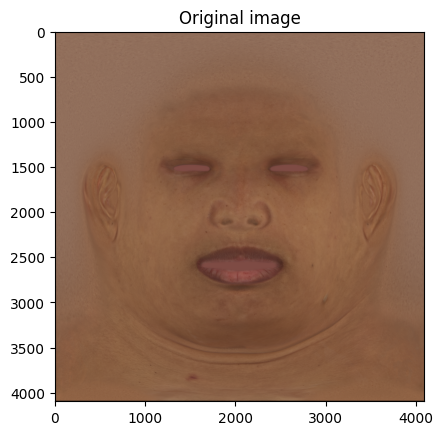

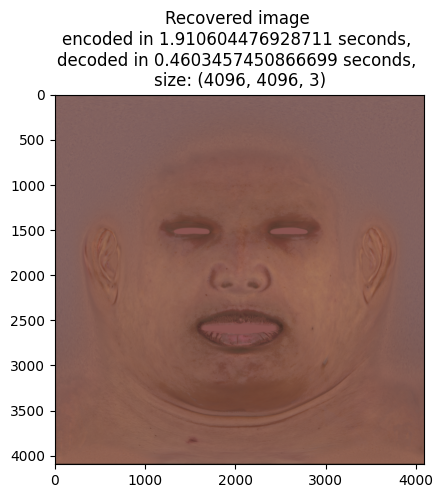

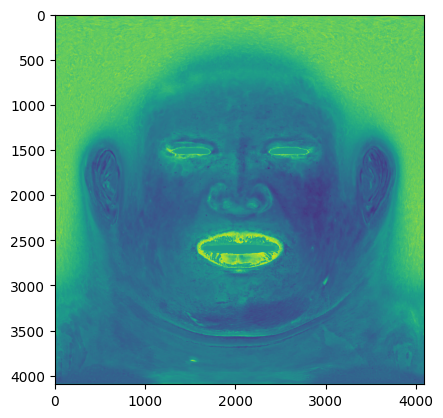

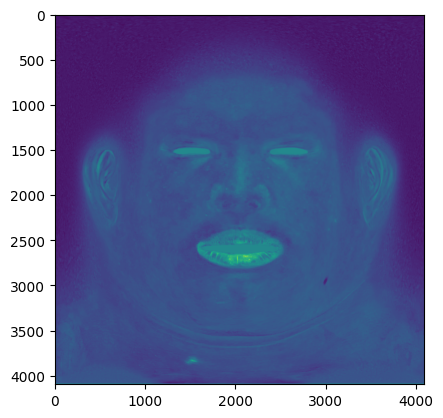

In [11]:
# fig,ax = plt.subplots(5,5, figsize=(16,14))
names = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
idx = 0
WIDTH = 4096
HEIGHT = 4096

# for image, name in zip(images, names):
# image = r"C:\Users\joeli\OneDrive\Desktop\AE_2023_06\models_4k\m46_4k.png"
image = r"C:\Users\joeli\Dropbox\Data\models_4k\m46_4k.png"
#load image
image = Image.open(image).convert('RGB')


image = np.array(image).astype('float32')/255.0
WIDTH = image.shape[0]
HEIGHT = image.shape[1]
image = np.asarray(image)
image_numpy = image.reshape((WIDTH, HEIGHT, 3))
pred_maps, encode_time = encode(image_numpy)
print(f"shape of pred_maps: {pred_maps.shape}")
Cm = np.asarray(pred_maps[:,0])
Ch = np.asarray(pred_maps[:,1])
Bm = np.asarray(pred_maps[:,2])
Bh = np.asarray(pred_maps[:,3])
T = np.asarray(pred_maps[:,4])
av_T = np.mean(T)
max_T = np.max(T)
min_T = np.min(T)
av_Cm = np.mean(Cm)
max_Cm = np.max(Cm)
min_Cm = np.min(Cm)
av_Ch = np.mean(Ch)
max_Ch = np.max(Ch)
min_Ch = np.min(Ch)
min_Bm = np.min(Bm)
max_Bm = np.max(Bm)
av_Bm = np.mean(Bm)
min_Bh = np.min(Bh)
max_Bh = np.max(Bh)
av_Bh = np.mean(Bh)
# result_string = f"Cm: {av_Cm}, {max_Cm}, {min_Cm} | Ch: {av_Ch}, {max_Ch}, {min_Ch} | T: {av_T}, {max_T}, {min_T} | delta_e: {av_delta_e}, {max_delta_e}, {min_delta_e}"
result_string = f"Cm min: {min_Cm} Cm mean: {av_Cm}| Cm max: {max_Cm} | Ch min: {min_Ch} Ch mean: {av_Ch}| Ch max: {max_Ch} | T min: {min_T} T mean: {av_T}| T max: {max_T} | Bm min: {min_Bm} Bm mean: {av_Bm}| Bm max: {max_Bm} | Bh min: {min_Bh} Bh mean: {av_Bh}| Bh max: {max_Bh}"
print(result_string)
# pred_maps[:,0] = Cm*2+.01
#im Cm is negative add 0.01
# pred_maps[:,0] = np.where(pred_maps[:,0] < 0, pred_maps[:,0]+0.01, pred_maps[:,0])
#multiplay all pixels that are less than 2*Cm_av by 3
# pred_maps[:,0] = pred_maps[:,0]+(pred_maps[:,0]-av_Cm)
pred_maps[:,0] = pred_maps[:,0]*0.75

pred_maps[:,1] = np.where(pred_maps[:,1] > av_Ch*2, pred_maps[:,1], pred_maps[:,1]*2)
# pred_maps[:,1] = pred_maps[:,1]*2

# pred_maps[:,1] = pred_maps[:,1]*0.25
# pred_maps[:,2] = Bm*0.85
# pred_maps[:,3] = Bh*0.8
# pred_maps[:,4] = T*0.8
recovered, decode_time = decode(pred_maps)
print(f"shape of recovered: {recovered.shape}")
recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
# recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
# recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
#show original image
plt.imshow(image)
plt.title(f"Original image")
plt.show()
plt.imshow(recovered)
plt.title(f"Recovered image \nencoded in {encode_time} seconds, \ndecoded in {decode_time} seconds, \nsize: {recovered.shape}")

plt.show()
# #save the image 
# #print size of image
# print(f"size of image: {recovered.shape}")
# #max min pixel values
# print(f"max pixel value: {np.max(recovered)}")
# print(f"min pixel value: {np.min(recovered)}")
# #clamp the values to 0-1
# recovered = np.clip(recovered, 0, 1)
# # experiment_name = input("Enter experiment name: ")
file_NAME = "melTp25.png"
plt.imsave(file_NAME, recovered)
# idx += 1
# #save the image
plt.imsave(f"hem_T2.png", recovered)
#show hemoglobin and oxygenation maps
plt.imshow(pred_maps[:,1].reshape((WIDTH, HEIGHT)), cmap=my_config.CMAP_SPECULAR)
plt.show()
plt.imshow(pred_maps[:,3].reshape((WIDTH, HEIGHT)), cmap=my_config.CMAP_SPECULAR)
plt.show()